In [32]:
import xarray as xr

In [2]:
core_profiles = xr.open_dataset(
    "~/core_profiles.h5",
    engine="h5netcdf",
    group="core_profiles",
    phony_dims="access",
)

In [3]:
core_profiles = (
    core_profiles.drop_dims("phony_dim_1")
    .swap_dims(
        {
            "phony_dim_0": "time",
            "phony_dim_2": "rho_tor_norm",
            "phony_dim_3": "ion",
        }
    )
    .set_coords(
        [
            "profiles_1d[]&grid&rho_tor_norm",
            "profiles_1d[]&ion[]&label",
        ]
    )
    .rename_vars(
        {
            "profiles_1d[]&grid&rho_tor_norm": "rho_tor_norm",
            "profiles_1d[]&ion[]&label": "ion",
        }
    )
)

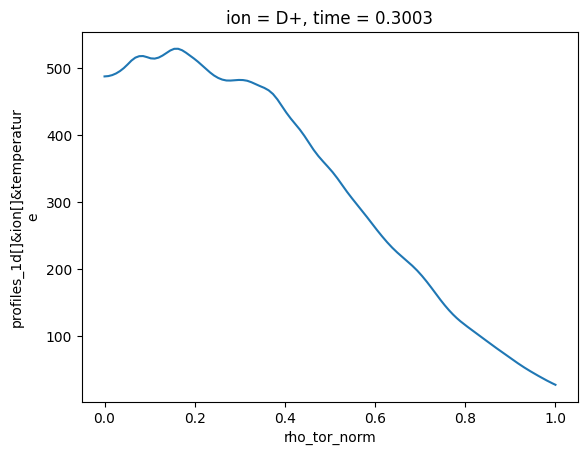

In [30]:
core_profiles["profiles_1d[]&ion[]&temperature"].isel(time=0, ion=0).plot()